# This notebook is to create the "nearest stop" and "mean tea from nearest to destination" (mteapath) features

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
from jupyterthemes import jtplot
import datetime as dt
import seaborn as sns
import json
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

ROOT_DIR = '/home/miguel/github_repos/python-ds'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')

DATA = os.path.join(DATA_INTERIM, 'data.pkl')
PATHS = os.path.join(DATA_PROCESSED, 'paths.pkl')
SIM_DATA = os.path.join(DATA_INTERIM, 'sim_data.pkl')
DISTS_TAS = os.path.join(DATA_INTERIM, 'dists_and_tas.pkl')
TOTAL_DATA = os.path.join(DATA_INTERIM, 'total_data.pkl')

X_TRAIN = os.path.join(DATA_PROCESSED, 'X_train.pkl')
X_VAL = os.path.join(DATA_PROCESSED, 'X_val.pkl')
X_TEST = os.path.join(DATA_PROCESSED, 'X_test.pkl')
Y_TRAIN = os.path.join(DATA_PROCESSED, 'y_train.pkl')
Y_VAL = os.path.join(DATA_PROCESSED, 'y_val.pkl')
Y_TEST = os.path.join(DATA_PROCESSED, 'y_test.pkl')

VAL_SET = os.path.join(DATA_PROCESSED, 'eval_set.pkl')
TEST_SET = os.path.join(DATA_PROCESSED, 'test_set.pkl')

SRC_DIR = os.path.join(ROOT_DIR, 'src')

import sys
sys.path.append(SRC_DIR)

import data.create_from_sim as cfs
import data.create_from_txt as cft
import data.paths as p
import data.target_creation as tc
import evaluation.eval as ev
import features.input_dataframe as input_d

import xgboost as xgb

In [2]:
X_train = pd.read_pickle(X_TRAIN)

In [3]:
X_train.head()

bus_stop  codigoBus      distance        lat linea       long  \
1      2960        262  13088.906612 -34.906445  1476 -56.200943   
2      2964        262  13594.140293 -34.906445  1476 -56.200943   
5      2969        262   4117.478660 -34.906445  1476 -56.200943   
6      2970        262   4369.975910 -34.906445  1476 -56.200943   
7      2971        262   5240.147941 -34.906445  1476 -56.200943   

            timestamp       uid            x           y  
1 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943  
2 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943  
5 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943  
6 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943  
7 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943

In [4]:
def feat_nearest_stop(X):
    """
    Find the nearest stop for each record.
    Args:
        X (pd.DataFrame): Must have the distances to all the bus stops 
            in its line path.
    Returns:
        pd.DataFrame: The same as the input with the nearest stop feature added.
    """
    X['nearest_stop'] = X[X.columns[
        X.columns.str.contains('d_')]
                         ].idxmin(axis=1).apply(lambda x: int(x.split('_')[1]))
    return X

In [5]:
X = X_train

In [6]:
EASY_DISTS = os.path.join(DATA_INTERIM, 'easy_dists.pkl')
X = pd.read_pickle(EASY_DISTS)
X.head()

codigoBus        lat linea       long           timestamp       uid  \
24         275 -34.883250  1476 -56.083275 2018-10-02 14:04:37  1476_275   
25         263 -34.903110  1476 -56.165750 2018-10-02 14:04:37  1476_263   
49         525 -34.904220  1476 -56.182335 2018-10-02 14:04:37  1476_525   
157        278 -34.894333  1476 -56.109890 2018-10-02 14:04:37  1476_278   
212        275 -34.883167  1476 -56.083305 2018-10-02 14:04:52  1476_275   

                x            y  d_553  d_554   ...    d_6193  d_6194  d_6195  \
24   10972.457722  2227.234381    NaN    NaN   ...       NaN     NaN     NaN   
25    2344.403657    18.903138    NaN    NaN   ...       NaN     NaN     NaN   
49     609.377568  -104.523231    NaN    NaN   ...       NaN     NaN     NaN   
157   8188.151460   994.861009    NaN    NaN   ...       NaN     NaN     NaN   
212  10969.319297  2236.463560    NaN    NaN   ...       NaN     NaN     NaN   

     d_6196        d_6274  d_6276  d_6283  d_6284  d_6299  d_6301  
24      NaN  12585.578919     NaN     NaN     NaN     NaN     NaN  
25      NaN   3709.119908     NaN     NaN     NaN     NaN     NaN  
49      NaN   1971.069917     NaN     NaN     NaN     NaN     NaN  
157     NaN   9628.891538     NaN     NaN     NaN     NaN     NaN  
212     NaN  12584.401298     NaN     NaN     NaN     NaN     NaN  

[5 rows x 1052 columns]

In [7]:
data = X.iloc[:10000]

In [8]:
X['nearest_stop'] = X[X.columns[
    X.columns.str.contains('d_')]
 ].idxmin(axis=1).apply(lambda x: int(x.split('_')[1]))
X.head()

codigoBus        lat linea       long           timestamp       uid  \
24         275 -34.883250  1476 -56.083275 2018-10-02 14:04:37  1476_275   
25         263 -34.903110  1476 -56.165750 2018-10-02 14:04:37  1476_263   
49         525 -34.904220  1476 -56.182335 2018-10-02 14:04:37  1476_525   
157        278 -34.894333  1476 -56.109890 2018-10-02 14:04:37  1476_278   
212        275 -34.883167  1476 -56.083305 2018-10-02 14:04:52  1476_275   

                x            y  d_553  d_554      ...       d_6194  d_6195  \
24   10972.457722  2227.234381    NaN    NaN      ...          NaN     NaN   
25    2344.403657    18.903138    NaN    NaN      ...          NaN     NaN   
49     609.377568  -104.523231    NaN    NaN      ...          NaN     NaN   
157   8188.151460   994.861009    NaN    NaN      ...          NaN     NaN   
212  10969.319297  2236.463560    NaN    NaN      ...          NaN     NaN   

     d_6196        d_6274  d_6276  d_6283  d_6284  d_6299  d_6301  \
24      NaN  12585.578919     NaN     NaN     NaN     NaN     NaN   
25      NaN   3709.119908     NaN     NaN     NaN     NaN     NaN   
49      NaN   1971.069917     NaN     NaN     NaN     NaN     NaN   
157     NaN   9628.891538     NaN     NaN     NaN     NaN     NaN   
212     NaN  12584.401298     NaN     NaN     NaN     NaN     NaN   

     nearest_stop  
24           2968  
25           4003  
49           4204  
157          3250  
212          2968  

[5 rows x 1053 columns]

In [9]:
nsX = feat_nearest_stop(X)
print(nsX.shape)
nsX.head()

(140060, 1053)


codigoBus        lat linea       long           timestamp       uid  \
24         275 -34.883250  1476 -56.083275 2018-10-02 14:04:37  1476_275   
25         263 -34.903110  1476 -56.165750 2018-10-02 14:04:37  1476_263   
49         525 -34.904220  1476 -56.182335 2018-10-02 14:04:37  1476_525   
157        278 -34.894333  1476 -56.109890 2018-10-02 14:04:37  1476_278   
212        275 -34.883167  1476 -56.083305 2018-10-02 14:04:52  1476_275   

                x            y  d_553  d_554      ...       d_6194  d_6195  \
24   10972.457722  2227.234381    NaN    NaN      ...          NaN     NaN   
25    2344.403657    18.903138    NaN    NaN      ...          NaN     NaN   
49     609.377568  -104.523231    NaN    NaN      ...          NaN     NaN   
157   8188.151460   994.861009    NaN    NaN      ...          NaN     NaN   
212  10969.319297  2236.463560    NaN    NaN      ...          NaN     NaN   

     d_6196        d_6274  d_6276  d_6283  d_6284  d_6299  d_6301  \
24      NaN  12585.578919     NaN     NaN     NaN     NaN     NaN   
25      NaN   3709.119908     NaN     NaN     NaN     NaN     NaN   
49      NaN   1971.069917     NaN     NaN     NaN     NaN     NaN   
157     NaN   9628.891538     NaN     NaN     NaN     NaN     NaN   
212     NaN  12584.401298     NaN     NaN     NaN     NaN     NaN   

     nearest_stop  
24           2968  
25           4003  
49           4204  
157          3250  
212          2968  

[5 rows x 1053 columns]

## Bus stop pairs mean ta

In [10]:
data = pd.read_pickle(TOTAL_DATA)
print(data.shape)
data.head()

(3506879, 11)


bus_stop  codigoBus      distance        lat linea       long  \
1      2960        262  13088.906612 -34.906445  1476 -56.200943   
2      2964        262  13594.140293 -34.906445  1476 -56.200943   
5      2969        262   4117.478660 -34.906445  1476 -56.200943   
6      2970        262   4369.975910 -34.906445  1476 -56.200943   
7      2971        262   5240.147941 -34.906445  1476 -56.200943   

                       ta           timestamp       uid            x  \
1 2018-10-02 17:59:05.500 2018-10-02 17:12:57  1476_262 -1337.282996   
2 2018-10-02 17:57:58.000 2018-10-02 17:12:57  1476_262 -1337.282996   
5 2018-10-02 17:31:42.000 2018-10-02 17:12:57  1476_262 -1337.282996   
6 2018-10-02 17:33:04.500 2018-10-02 17:12:57  1476_262 -1337.282996   
7 2018-10-02 17:36:19.500 2018-10-02 17:12:57  1476_262 -1337.282996   

            y  
1 -351.931943  
2 -351.931943  
5 -351.931943  
6 -351.931943  
7 -351.931943

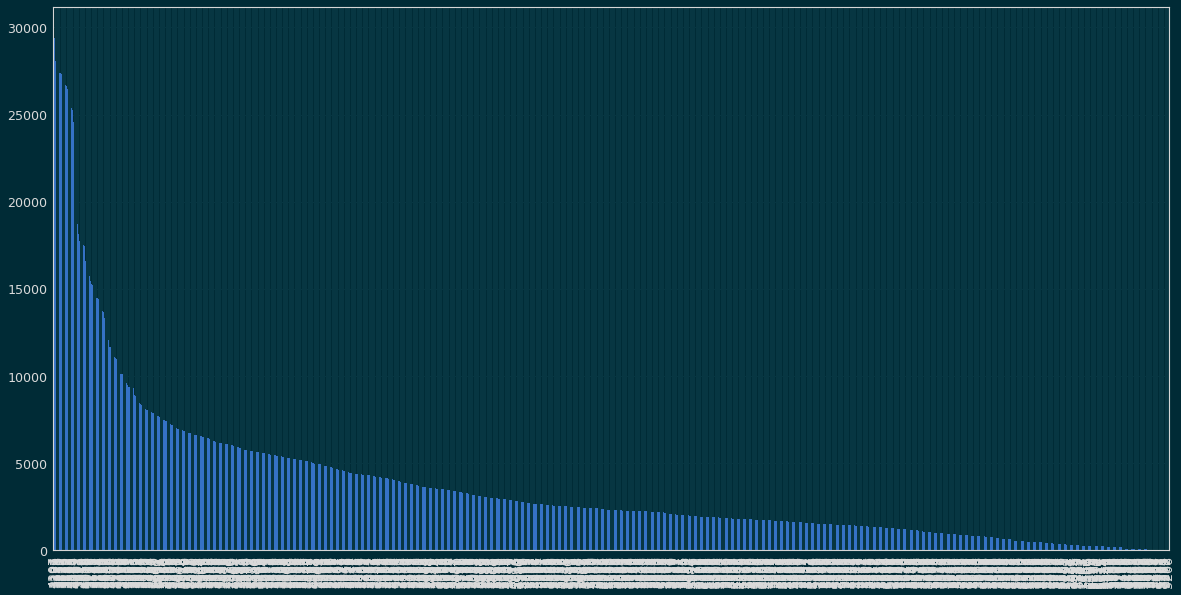

In [11]:
data.bus_stop.value_counts().plot('bar')

In [12]:
data.bus_stop.unique().shape

(935,)

In [13]:
paths = pd.read_pickle(PATHS)

In [14]:
paths.linea.unique().shape

(103,)

In [15]:
paths.head()

calle  codigoParada           esquina        lat  \
0  AV DRA MA L SALDUN DE RODRIGUEZ          4836        AV BOLIVIA -34.881817   
1                       AV BOLIVIA          2953       JOSE ORDEIG -34.879045   
2                       AV BOLIVIA          2954            VERONA -34.877140   
3                       AV BOLIVIA          2955  DR ELIAS REGULES -34.875377   
4                       AV BOLIVIA          2956          CALLE N1 -34.873713   

  linea       long  ordinal             x            y  
0   217 -56.083301        1  10969.744826  2386.594612  
1   217 -56.085743        2  10714.269869  2694.818891  
2   217 -56.088758        3  10398.836431  2906.584242  
3   217 -56.091500        4  10112.028195  3102.689054  
4   217 -56.094133        5   9836.567948  3287.715835

In [16]:
path_l = paths[paths.linea == '217'].copy()

In [17]:
path_l.shape

(62, 9)

In [18]:
path_l['next_stop'] = path_l.codigoParada.shift(-1)
pairs = path_l[['codigoParada', 'next_stop']].iloc[:-1].astype(int)
pairs.head()

codigoParada  next_stop
0          4836       2953
1          2953       2954
2          2954       2955
3          2955       2956
4          2956       2957

In [19]:
pairs = [tuple(x) for x in pairs.values]
pairs[:5]

[(4836, 2953), (2953, 2954), (2954, 2955), (2955, 2956), (2956, 2957)]

In [20]:
def get_line_pairs(line, paths=paths):
    """ Gets all the consecutive bus stop pairs for the line."""
    path_l = paths[paths.linea == line].copy()
    path_l['next_stop'] = path_l.codigoParada.shift(-1)
    pairs = path_l[['codigoParada', 'next_stop']].iloc[:-1].astype(int)
    return [tuple(x) for x in pairs.values]

In [21]:
paths.linea.unique()

array(['217', '218', '227', '231', '237', '242', '254', '266', '278',
       '280', '338', '339', '340', '343', '372', '395', '413', '417',
       '434', '442', '452', '455', '498', '522', '554', '562', '569',
       '571', '575', '585', '591', '593', '595', '602', '852', '856',
       '863', '864', '865', '869', '873', '874', '1459', '1464', '1476',
       '1483', '1730', '1736', '2208', '2209', '2388', '2390', '2391',
       '2392', '2393', '2460', '2461', '2791', '2792', '2921', '2922',
       '2955', '2956', '2963', '2964', '3071', '3072', '3075', '3076',
       '3077', '3078', '3079', '3080', '3296', '3297', '7512', '7513',
       '7526', '7529', '7538', '7539', '7626', '7627', '7703', '7704',
       '7705', '7706', '7896', '7897', '7898', '7899', '7902', '7903',
       '7912', '7913', '7918', '7919', '7920', '7921', '7926', '7927',
       '7928', '7929'], dtype=object)

In [22]:
get_line_pairs('3079')[:5]

[(4760, 4042), (4042, 574), (574, 575), (575, 577), (577, 579)]

In [23]:
def get_all_stop_pairs(paths):
    """ Gets the consecutive bus stop pairs for all lines."""
    pairs = set()
    for line in paths.linea.unique():
        pairs |= set(get_line_pairs(line, paths))
    return list(pairs)

In [24]:
stop_pairs = get_all_stop_pairs(paths)

In [25]:
stop_pairs[:5]

[(3670, 3671), (1482, 1483), (2474, 2475), (3881, 3182), (3849, 4002)]

In [26]:
len(stop_pairs)

1187

In [27]:
data.head()

bus_stop  codigoBus      distance        lat linea       long  \
1      2960        262  13088.906612 -34.906445  1476 -56.200943   
2      2964        262  13594.140293 -34.906445  1476 -56.200943   
5      2969        262   4117.478660 -34.906445  1476 -56.200943   
6      2970        262   4369.975910 -34.906445  1476 -56.200943   
7      2971        262   5240.147941 -34.906445  1476 -56.200943   

                       ta           timestamp       uid            x  \
1 2018-10-02 17:59:05.500 2018-10-02 17:12:57  1476_262 -1337.282996   
2 2018-10-02 17:57:58.000 2018-10-02 17:12:57  1476_262 -1337.282996   
5 2018-10-02 17:31:42.000 2018-10-02 17:12:57  1476_262 -1337.282996   
6 2018-10-02 17:33:04.500 2018-10-02 17:12:57  1476_262 -1337.282996   
7 2018-10-02 17:36:19.500 2018-10-02 17:12:57  1476_262 -1337.282996   

            y  
1 -351.931943  
2 -351.931943  
5 -351.931943  
6 -351.931943  
7 -351.931943

In [28]:
data['in_the_stop'] = data.distance < 50
data.head()

bus_stop  codigoBus      distance        lat linea       long  \
1      2960        262  13088.906612 -34.906445  1476 -56.200943   
2      2964        262  13594.140293 -34.906445  1476 -56.200943   
5      2969        262   4117.478660 -34.906445  1476 -56.200943   
6      2970        262   4369.975910 -34.906445  1476 -56.200943   
7      2971        262   5240.147941 -34.906445  1476 -56.200943   

                       ta           timestamp       uid            x  \
1 2018-10-02 17:59:05.500 2018-10-02 17:12:57  1476_262 -1337.282996   
2 2018-10-02 17:57:58.000 2018-10-02 17:12:57  1476_262 -1337.282996   
5 2018-10-02 17:31:42.000 2018-10-02 17:12:57  1476_262 -1337.282996   
6 2018-10-02 17:33:04.500 2018-10-02 17:12:57  1476_262 -1337.282996   
7 2018-10-02 17:36:19.500 2018-10-02 17:12:57  1476_262 -1337.282996   

            y  in_the_stop  
1 -351.931943        False  
2 -351.931943        False  
5 -351.931943        False  
6 -351.931943        False  
7 -351.931943        False

In [29]:
stops_data = data[data.in_the_stop]
stops_data.head()

bus_stop  codigoBus   distance        lat linea       long  \
51       6274        262   9.026079 -34.906445  1476 -56.200943   
103      6274        262  24.382797 -34.906500  1476 -56.200806   
155      6274        262  21.676631 -34.906580  1476 -56.200890   
693      3177        262  17.777287 -34.906530  1476 -56.196526   
745      3177        262  10.410186 -34.906303  1476 -56.196415   

                         ta           timestamp       uid            x  \
51  2018-10-02 17:13:19.500 2018-10-02 17:12:57  1476_262 -1337.282996   
103 2018-10-02 17:13:19.500 2018-10-02 17:13:12  1476_262 -1322.950854   
155 2018-10-02 17:13:19.500 2018-10-02 17:13:27  1476_262 -1331.738445   
693 2018-10-02 17:16:34.500 2018-10-02 17:16:12  1476_262  -875.202186   
745 2018-10-02 17:16:34.500 2018-10-02 17:16:27  1476_262  -863.590013   

              y  in_the_stop  
51  -351.931943         True  
103 -358.047664         True  
155 -366.943258         True  
693 -361.383512         True  
745 -336.142263         True

In [30]:
from numpy.linalg import norm

In [31]:
stop1 = 6274
stop2 = 3177

In [32]:
# Get the records that are in the stop1 (norm to position less than 50), 
#but have stop2 as destination

In [33]:
stop1_coords = paths[paths.codigoParada == stop1][['x', 'y']].values[0]
stop1_coords

array([-1346.24199035,  -350.8335253 ])

In [34]:
valid_data = data[data.bus_stop == stop2]
valid_data = valid_data[norm(valid_data[['x', 'y']] - stop1_coords, axis=1) < 50]
deltas = (valid_data.ta - valid_data.timestamp).apply(lambda x: x.total_seconds())
deltas.describe()

count     76.000000
mean     206.756579
std       56.368771
min       45.000000
25%      180.750000
50%      202.875000
75%      241.875000
max      337.500000
dtype: float64

In [35]:
def get_mean_pair_ta(stop_tuple, X):
    print(stop_tuple)
    stop1, stop2 = stop_tuple
    
    stop1_coords = paths[paths.codigoParada == stop1][['x', 'y']].values[0]
    valid_data = data[data.bus_stop == stop2]
    valid_data = valid_data[norm(valid_data[['x', 'y']] - stop1_coords, axis=1) < 50]
    deltas = (valid_data.ta - valid_data.timestamp).apply(lambda x: x.total_seconds())
    
    return deltas.mean()

In [36]:
def get_mean_stop_tas(stop_pairs, X):
    pairs_df = pd.DataFrame(stop_pairs, columns=['stop_0', 'stop_1'])
    pairs_df['mean_ta'] = pairs_df.apply(
        lambda x: get_mean_pair_ta(x.values, X=data), axis=1)
    return pairs_df

In [37]:
get_mean_pair_ta((stop1, stop2), data)

(6274, 3177)


206.7565789473684

In [38]:
np.array(stop_pairs).shape

(1187, 2)

In [39]:
pd.DataFrame(stop_pairs).head()

0     1
0  3670  3671
1  1482  1483
2  2474  2475
3  3881  3182
4  3849  4002

In [40]:
pairs_df = pd.DataFrame(stop_pairs, columns=['stop_0', 'stop_1'])
%time pairs_df['mean_ta'] = pairs_df.apply(lambda x: get_mean_pair_ta(x.values, X=data), axis=1)

[3670 3671]
[1482 1483]
[2474 2475]
[3881 3182]
[3849 4002]
[2823 4315]
[4863 2995]
[1576 1577]
[1480 1481]
[2504 2505]
[2542 2543]
[2270 2271]
[2850 2851]
[1503 1504]
[3185 3186]
[3936 3937]
[1137 1138]
[3764 3765]
[2492 5021]
[3865 3866]
[2704 3163]
[2979 2980]
[3157 4987]
[4901 4902]
[3270 4863]
[4087 4003]
[2930 2931]
[2802 2803]
[4960 1123]
[2931 2932]
[5363 5364]
[5491 5492]
[2803 2804]
[5615 5612]
[2081 2082]
[1131 1132]
[4878 5792]
[2282 5313]
[2051 5200]
[3062 3147]
[4028 4044]
[3692 3593]
[2039 4894]
[2460 3783]
[4890 3206]
[3014 3015]
[2046 4896]
[1124 1126]
[4314 5687]
[2828 2829]
[4876 4877]
[5364 5365]
[2538 2540]
[4504 4503]
[4908 4010]
[2787 2788]
[5487 5488]
[1127 1128]
[4864 3291]
[2902 2914]
[6193 6196]
[5078 5316]
[2610 2611]
[2510 2511]
[3207 6193]
[3588 3590]
[3669 3670]
[3151 3230]
[1534 1501]
[3065 3066]
[4842 6152]
[5302 5303]
[3254 3255]
[2813 2814]
[2604 3756]
[2502 4601]
[1145 1211]
[2274 2275]
[3246 3247]
[2047 2048]
[2609 2610]
[2801 2802]
[3672 2461]
[519

In [41]:
pairs_df.head()

stop_0  stop_1  mean_ta
0    3670    3671  303.214
1    1482    1483  1475.91
2    2474    2475  79.9468
3    3881    3182  1192.09
4    3849    4002  1320.97

In [42]:
data = pd.read_pickle(TOTAL_DATA)
paths = pd.read_pickle(PATHS)
stop_pairs = get_all_stop_pairs(paths)
stops_mean_tas = get_mean_stop_tas(stop_pairs, data).set_index(['stop_0', 'stop_1'])

[3670 3671]
[1482 1483]
[2474 2475]
[3881 3182]
[3849 4002]
[2823 4315]
[4863 2995]
[1576 1577]
[1480 1481]
[2504 2505]
[2542 2543]
[2270 2271]
[2850 2851]
[1503 1504]
[3185 3186]
[3936 3937]
[1137 1138]
[3764 3765]
[2492 5021]
[3865 3866]
[2704 3163]
[2979 2980]
[3157 4987]
[4901 4902]
[3270 4863]
[4087 4003]
[2930 2931]
[2802 2803]
[4960 1123]
[2931 2932]
[5363 5364]
[5491 5492]
[2803 2804]
[5615 5612]
[2081 2082]
[1131 1132]
[4878 5792]
[2282 5313]
[2051 5200]
[3062 3147]
[4028 4044]
[3692 3593]
[2039 4894]
[2460 3783]
[4890 3206]
[3014 3015]
[2046 4896]
[1124 1126]
[4314 5687]
[2828 2829]
[4876 4877]
[5364 5365]
[2538 2540]
[4504 4503]
[4908 4010]
[2787 2788]
[5487 5488]
[1127 1128]
[4864 3291]
[2902 2914]
[6193 6196]
[5078 5316]
[2610 2611]
[2510 2511]
[3207 6193]
[3588 3590]
[3669 3670]
[3151 3230]
[1534 1501]
[3065 3066]
[4842 6152]
[5302 5303]
[3254 3255]
[2813 2814]
[2604 3756]
[2502 4601]
[1145 1211]
[2274 2275]
[3246 3247]
[2047 2048]
[2609 2610]
[2801 2802]
[3672 2461]
[519

In [43]:
STOPS_MEAN_TAS = os.path.join(DATA_PROCESSED, 'stops_mean_tas.pkl')
stops_mean_tas.to_pickle(STOPS_MEAN_TAS)

In [44]:
line = '217'
stop1 = 2953
stop2 = 2817

In [45]:
line_path = paths[paths.linea == line]
ordinal1 = line_path[line_path.codigoParada == stop1].ordinal.values[0]
ordinal2 = line_path[line_path.codigoParada == stop2].ordinal.values[0]
print(ordinal1)
print(ordinal2)

2
8


In [47]:
sub_path = line_path[line_path.ordinal.isin(range(ordinal1, ordinal2 + 1))]
sub_path

calle  codigoParada           esquina        lat linea       long  \
1    AV BOLIVIA          2953       JOSE ORDEIG -34.879045   217 -56.085743   
2    AV BOLIVIA          2954            VERONA -34.877140   217 -56.088758   
3    AV BOLIVIA          2955  DR ELIAS REGULES -34.875377   217 -56.091500   
4    AV BOLIVIA          2956          CALLE N1 -34.873713   217 -56.094133   
5    AV BOLIVIA          2957    MANUEL TECHERA -34.873010   217 -56.095637   
6  CNO CARRASCO          2816          ONCATIVO -34.872004   217 -56.100368   
7  CNO CARRASCO          2817              LUGO -34.871164   217 -56.104095   

   ordinal             x            y  
1        2  10714.269869  2694.818891  
2        3  10398.836431  2906.584242  
3        4  10112.028195  3102.689054  
4        5   9836.567948  3287.715835  
5        6   9679.233429  3365.863449  
6        7   9184.259102  3477.785480  
7        8   8794.343837  3571.145178

In [48]:
pairs = get_all_stop_pairs(sub_path)
pairs

[(2816, 2817),
 (2954, 2955),
 (2956, 2957),
 (2953, 2954),
 (2955, 2956),
 (2957, 2816)]

In [49]:
pd.DataFrame([stops_mean_tas.loc[pair] for pair in pairs]).mean().values[0]

521.79256616709392

In [50]:
def summed_ta(stop1, stop2, line, mean_tas=stops_mean_tas, paths=paths):
    """ stop2 has to have an ordinal that is greater than the one of stop1. """
    line_path = paths[paths.linea == line]
    ordinal1 = line_path[line_path.codigoParada == stop1].ordinal.values[0]
    ordinal2 = line_path[line_path.codigoParada == stop2].ordinal.values[0]
    sub_path = line_path[line_path.ordinal.isin(range(ordinal1, ordinal2 + 1))]
    pairs = get_all_stop_pairs(sub_path)
    
    return pd.DataFrame(
        [stops_mean_tas.loc[pair] for pair in pairs]).mean().values[0]

In [51]:
%time summed_ta(stop1, stop2, line)

CPU times: user 44.9 ms, sys: 74 µs, total: 45 ms
Wall time: 43 ms


521.79256616709392

Let's use the saved function

In [52]:
import features.mean_stops_tas as mst

In [53]:
%time mst.summed_ta(stop1, stop2, line)

CPU times: user 31.3 ms, sys: 3.94 ms, total: 35.3 ms
Wall time: 34.8 ms


521.79256616709392

## Let's generate the training data

In [54]:
X_train = pd.read_pickle(X_TRAIN)
X_val = pd.read_pickle(X_VAL)
X_test = pd.read_pickle(X_TEST)

In [55]:
X_train.head()

bus_stop  codigoBus      distance        lat linea       long  \
1      2960        262  13088.906612 -34.906445  1476 -56.200943   
2      2964        262  13594.140293 -34.906445  1476 -56.200943   
5      2969        262   4117.478660 -34.906445  1476 -56.200943   
6      2970        262   4369.975910 -34.906445  1476 -56.200943   
7      2971        262   5240.147941 -34.906445  1476 -56.200943   

            timestamp       uid            x           y  
1 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943  
2 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943  
5 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943  
6 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943  
7 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943

In [56]:
import features.input_dataframe as input_d

In [60]:
data = input_d.parse_file()

276222it [00:12, 22912.01it/s]


('1476', '1483', '217', '218', '227', '231', '237', '2388', '2390', '2391', '2392', '2393', '242', '254', '266', '278', '340', '343', '372', '395', '498', '522', '7512', '7526', '7529', '7703', '7704', '7898', '7899', '7902', '7903', '7918', '7919', '7920', '7921', '7926', '7927', '7928', '7929', '863', '873')
('1476', '1483', '217', '218', '227', '231', '237', '2388', '2390', '2391', '2392', '2393', '242', '254', '266', '278', '340', '343', '372', '395', '498', '522', '7512', '7526', '7529', '7703', '7704', '7898', '7899', '7902', '7903', '7918', '7919', '7920', '7921', '7926', '7927', '7928', '7929', '863', '873')


In [61]:
print(data.shape)
data.head()

(7060114, 11)


bus_stop  codigoBus     distance        lat linea       long  nearest_stop  \
0      2959        275   601.438484 -34.883167  1476 -56.083305          2968   
1      2960        275   904.535211 -34.883167  1476 -56.083305          2968   
2      2964        275  1470.162222 -34.883167  1476 -56.083305          2968   
3      2967        275   317.023114 -34.883167  1476 -56.083305          2968   
4      2968        275    43.922621 -34.883167  1476 -56.083305          2968   

            timestamp       uid             x           y  
0 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  
1 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  
2 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  
3 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  
4 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356

In [62]:
data.to_pickle(os.path.join(DATA_INTERIM, 'total_data2.pkl'))

In [63]:
import features.mean_stops_tas as mst

In [65]:
record = data.iloc[0]
record

bus_stop                       2959
codigoBus                       275
distance                    601.438
lat                        -34.8832
linea                          1476
long                       -56.0833
nearest_stop                   2968
timestamp       2018-10-02 14:04:52
uid                        1476_275
x                           10969.3
y                           2236.46
Name: 0, dtype: object

In [67]:
def summed_ta_record(record):
    return mst.summed_ta(record.nearest_stop, record.bus_stop, record.linea)

In [76]:
summed_ta_record(record)

418.52222222222224

In [77]:
sub_data = data.iloc[:100]

In [82]:
def feat_mean_tas(data):
    """
    Adds the mean ta, from the nearest bus stop to the 'target' bus stop.
    The TA is calculated as the sum of the mean TAs for each stop-to-stop segment
    in the corresponding line.
    """
    data['mean_ta']  = data.apply(mst.summed_ta_record, axis=1)
    return data

In [83]:
%time new_data = feat_mean_tas(sub_data)
new_data.head()

CPU times: user 7.06 s, sys: 33.2 ms, total: 7.09 s
Wall time: 7.12 s


/home/miguel/anaconda3/envs/desafiotea/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


bus_stop  codigoBus     distance        lat linea       long  nearest_stop  \
0      2959        275   601.438484 -34.883167  1476 -56.083305          2968   
1      2960        275   904.535211 -34.883167  1476 -56.083305          2968   
2      2964        275  1470.162222 -34.883167  1476 -56.083305          2968   
3      2967        275   317.023114 -34.883167  1476 -56.083305          2968   
4      2968        275    43.922621 -34.883167  1476 -56.083305          2968   

            timestamp       uid             x           y      mean_ta  
0 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356   418.522222  
1 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356   469.736508  
2 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  3359.400442  
3 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356    84.522222  
4 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356     0.000000

In [84]:
new_data.isnull().sum()

bus_stop        0
codigoBus       0
distance        0
lat             0
linea           0
long            0
nearest_stop    0
timestamp       0
uid             0
x               0
y               0
mean_ta         0
dtype: int64

In [85]:
data.shape

(7060114, 11)

Let's generate all the data

In [98]:
%time new_data = input_d.feat_mean_tas(sub_data)

CPU times: user 6.28 s, sys: 21.7 ms, total: 6.3 s
Wall time: 6.32 s


In [88]:
new_data.shape

(100, 12)

In [89]:
new_data.head()

bus_stop  codigoBus     distance        lat linea       long  nearest_stop  \
0      2959        275   601.438484 -34.883167  1476 -56.083305          2968   
1      2960        275   904.535211 -34.883167  1476 -56.083305          2968   
2      2964        275  1470.162222 -34.883167  1476 -56.083305          2968   
3      2967        275   317.023114 -34.883167  1476 -56.083305          2968   
4      2968        275    43.922621 -34.883167  1476 -56.083305          2968   

            timestamp       uid             x           y      mean_ta  
0 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356   418.522222  
1 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356   469.736508  
2 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  3359.400442  
3 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356    84.522222  
4 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356     0.000000

In [100]:
sub_data = sub_data.drop('mean_ta', axis=1)
sub_data.head()

bus_stop  codigoBus     distance        lat linea       long  nearest_stop  \
0      2959        275   601.438484 -34.883167  1476 -56.083305          2968   
1      2960        275   904.535211 -34.883167  1476 -56.083305          2968   
2      2964        275  1470.162222 -34.883167  1476 -56.083305          2968   
3      2967        275   317.023114 -34.883167  1476 -56.083305          2968   
4      2968        275    43.922621 -34.883167  1476 -56.083305          2968   

            timestamp       uid             x           y  
0 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  
1 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  
2 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  
3 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  
4 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356

In [103]:
%time sub_data = input_d.feat_mean_tas(sub_data)

CPU times: user 6.18 s, sys: 27 ms, total: 6.2 s
Wall time: 6.19 s


In [106]:
sub_data['tea'] = 500

In [107]:
sub_data.head()

bus_stop  codigoBus     distance        lat linea       long  nearest_stop  \
0      2959        275   601.438484 -34.883167  1476 -56.083305          2968   
1      2960        275   904.535211 -34.883167  1476 -56.083305          2968   
2      2964        275  1470.162222 -34.883167  1476 -56.083305          2968   
3      2967        275   317.023114 -34.883167  1476 -56.083305          2968   
4      2968        275    43.922621 -34.883167  1476 -56.083305          2968   

            timestamp       uid             x           y      mean_ta  tea  
0 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356   418.522222  500  
1 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356   469.736508  500  
2 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  3359.400442  500  
3 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356    84.522222  500  
4 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356     0.000000  500

In [110]:
high = 1.5
low = 0.5

In [130]:
outliers = (sub_data.tea > high * sub_data.mean_ta) | (sub_data.tea < low * sub_data.mean_ta)
# weird_data = sub_data[].copy()

In [134]:
sub_data.loc[outliers, 'tea'] = sub_data.loc[outliers, 'mean_ta']

In [135]:
sub_data.shape

(100, 13)

In [136]:
sub_data.head()

bus_stop  codigoBus     distance        lat linea       long  nearest_stop  \
0      2959        275   601.438484 -34.883167  1476 -56.083305          2968   
1      2960        275   904.535211 -34.883167  1476 -56.083305          2968   
2      2964        275  1470.162222 -34.883167  1476 -56.083305          2968   
3      2967        275   317.023114 -34.883167  1476 -56.083305          2968   
4      2968        275    43.922621 -34.883167  1476 -56.083305          2968   

            timestamp       uid             x           y      mean_ta  \
0 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356   418.522222   
1 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356   469.736508   
2 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  3359.400442   
3 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356    84.522222   
4 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356     0.000000   

           tea  
0   500.000000  
1   500.000000  
2  3359.400442  
3    84.522222  
4     0.000000

In [125]:
weird_data.shape

(95, 13)

In [126]:
weird_data.tea = weird_data.mean_ta

In [128]:
weird_data.head()

bus_stop  codigoBus     distance        lat linea       long  nearest_stop  \
2      2964        275  1470.162222 -34.883167  1476 -56.083305          2968   
3      2967        275   317.023114 -34.883167  1476 -56.083305          2968   
4      2968        275    43.922621 -34.883167  1476 -56.083305          2968   
5      2969        275  8494.031762 -34.883167  1476 -56.083305          2968   
6      2970        275  8256.683539 -34.883167  1476 -56.083305          2968   

            timestamp       uid             x           y       mean_ta  \
2 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356   3359.400442   
3 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356     84.522222   
4 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356      0.000000   
5 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  18491.151222   
6 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  18267.187739   

            tea  
2   3359.400442  
3     84.522222  
4      0.000000  
5  18491.151222  
6  18267.187739

In [129]:
sub_data.head()

bus_stop  codigoBus     distance        lat linea       long  nearest_stop  \
0      2959        275   601.438484 -34.883167  1476 -56.083305          2968   
1      2960        275   904.535211 -34.883167  1476 -56.083305          2968   
2      2964        275  1470.162222 -34.883167  1476 -56.083305          2968   
3      2967        275   317.023114 -34.883167  1476 -56.083305          2968   
4      2968        275    43.922621 -34.883167  1476 -56.083305          2968   

            timestamp       uid             x           y      mean_ta  tea  
0 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356   418.522222  500  
1 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356   469.736508  500  
2 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  3359.400442  500  
3 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356    84.522222  500  
4 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356     0.000000  500

In [137]:
data.head()

bus_stop  codigoBus     distance        lat linea       long  nearest_stop  \
0      2959        275   601.438484 -34.883167  1476 -56.083305          2968   
1      2960        275   904.535211 -34.883167  1476 -56.083305          2968   
2      2964        275  1470.162222 -34.883167  1476 -56.083305          2968   
3      2967        275   317.023114 -34.883167  1476 -56.083305          2968   
4      2968        275    43.922621 -34.883167  1476 -56.083305          2968   

            timestamp       uid             x           y  
0 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  
1 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  
2 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  
3 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  
4 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356

In [138]:
data.to_pickle(os.path.join(DATA_INTERIM, 'total_data3.pkl'))

In [139]:
data.head()

bus_stop  codigoBus     distance        lat linea       long  nearest_stop  \
0      2959        275   601.438484 -34.883167  1476 -56.083305          2968   
1      2960        275   904.535211 -34.883167  1476 -56.083305          2968   
2      2964        275  1470.162222 -34.883167  1476 -56.083305          2968   
3      2967        275   317.023114 -34.883167  1476 -56.083305          2968   
4      2968        275    43.922621 -34.883167  1476 -56.083305          2968   

            timestamp       uid             x           y  
0 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  
1 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  
2 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  
3 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356  
4 2018-10-02 14:04:52  1476_275  10969.319297  2236.46356

In [140]:
X_train.head()

bus_stop  codigoBus      distance        lat linea       long  \
1      2960        262  13088.906612 -34.906445  1476 -56.200943   
2      2964        262  13594.140293 -34.906445  1476 -56.200943   
5      2969        262   4117.478660 -34.906445  1476 -56.200943   
6      2970        262   4369.975910 -34.906445  1476 -56.200943   
7      2971        262   5240.147941 -34.906445  1476 -56.200943   

            timestamp       uid            x           y  
1 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943  
2 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943  
5 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943  
6 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943  
7 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943

### Let's compute the targets in parallel

In [4]:
data = pd.read_pickle(os.path.join(DATA_INTERIM, 'total_data3.pkl'))

In [ ]:
target_data = utils.apply_parallel(data.groupby('uid'), tc.fill_one_uid_para)
target_data = target_data.reset_index().drop('group_index', axis=1)
target_data.to_pickle(os.path.join(DATA_INTERIM, 'total_data3.pkl'))

In [40]:
%time data = input_d.parse_file()

2064it [00:00, 20636.92it/s]

parsing data


276222it [00:11, 23974.46it/s]


getting distances
('1476', '1483', '217', '218', '227', '231', '237', '2388', '2390', '2391', '2392', '2393', '242', '254', '266', '278', '340', '343', '372', '395', '498', '522', '7512', '7526', '7529', '7703', '7704', '7898', '7899', '7902', '7903', '7918', '7919', '7920', '7921', '7926', '7927', '7928', '7929', '863', '873')
nearest stop
target creation
('1476_262', '1476_263', '1476_275', '1476_276', '1476_278', '1476_285', '1476_525', '1476_570', '1476_589', '1476_962', '1476_969', '1483_254', '1483_262', '1483_275', '1483_285', '1483_525', '1483_536', '1483_570', '1483_589', '1483_678', '1483_770', '1483_962', '1483_969', '217_10', '217_105', '217_13', '217_15', '217_20', '217_29', '217_34', '217_40', '217_45', '217_5', '217_52', '217_68', '217_76', '217_82', '217_88', '217_90', '217_91', '217_99', '218_10', '218_105', '218_13', '218_15', '218_20', '218_29', '218_34', '218_40', '218_45', '218_5', '218_52', '218_68', '218_76', '218_82', '218_88', '218_90', '218_91', '218_99', '227

In [41]:
data.to_pickle(os.path.join(DATA_INTERIM, 'data_final.pkl'))

In [42]:
data.head()

bus_stop  codigoBus      distance        lat linea       long  \
1      2960        262  13088.906612 -34.906445  1476 -56.200943   
2      2964        262  13594.140293 -34.906445  1476 -56.200943   
5      2969        262   4117.478660 -34.906445  1476 -56.200943   
6      2970        262   4369.975910 -34.906445  1476 -56.200943   
7      2971        262   5240.147941 -34.906445  1476 -56.200943   

   nearest_stop                      ta           timestamp       uid  \
1          6274 2018-10-02 17:59:05.500 2018-10-02 17:12:57  1476_262   
2          6274 2018-10-02 17:57:58.000 2018-10-02 17:12:57  1476_262   
5          6274 2018-10-02 17:31:42.000 2018-10-02 17:12:57  1476_262   
6          6274 2018-10-02 17:33:04.500 2018-10-02 17:12:57  1476_262   
7          6274 2018-10-02 17:36:19.500 2018-10-02 17:12:57  1476_262   

             x           y  
1 -1337.282996 -351.931943  
2 -1337.282996 -351.931943  
5 -1337.282996 -351.931943  
6 -1337.282996 -351.931943  
7 -1337.282996 -351.931943

In [43]:
data.shape

(3393168, 12)

In [44]:
data.timestamp.apply(lambda x: x.date()).value_counts()

2018-10-02    3393168
Name: timestamp, dtype: int64

In [51]:
split_index = np.round(data.shape[0] * 0.7).astype(int)

In [55]:
xy_train = data.iloc[:split_index]
xy_val = data.iloc[split_index:]

X_train = xy_train.drop('ta', axis=1)
y_train = xy_train['ta']
X_val = xy_val.drop('ta', axis=1)
y_val = xy_val['ta']

In [56]:
X_TRAIN_FINAL = os.path.join(DATA_PROCESSED, 'X_train_final.pkl')
Y_TRAIN_FINAL = os.path.join(DATA_PROCESSED, 'y_train_final.pkl')
X_VAL_FINAL = os.path.join(DATA_PROCESSED, 'X_val_final.pkl')
Y_VAL_FINAL = os.path.join(DATA_PROCESSED, 'y_val_final.pkl')

In [57]:
X_train.to_pickle(X_TRAIN_FINAL)
y_train.to_pickle(Y_TRAIN_FINAL)
X_val.to_pickle(X_VAL_FINAL)
y_val.to_pickle(Y_VAL_FINAL)

In [59]:
X_DATA_FINAL = os.path.join(DATA_PROCESSED, 'X_data_final.pkl')
Y_DATA_FINAL = os.path.join(DATA_PROCESSED, 'y_data_final.pkl')

In [60]:
X_data = data.drop('ta', axis=1)
y_data = data['ta']

X_data.to_pickle(X_DATA_FINAL)
y_data.to_pickle(Y_DATA_FINAL)